In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

In [22]:
# Load training and testing data from google drive.
df_test = pd.read_csv('/content/drive/My Drive/data/test.csv')
df_train = pd.read_csv('/content/drive/My Drive/data/train.csv')

In [23]:
# View training data rows.
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [24]:
df_test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [25]:
# Frequency Encoding for 'state'
frq_dis = df_train.groupby('state').size()/len(df_train)
df_train["state"] = df_train.state.map(frq_dis)
frq_dis = df_test.groupby('state').size()/len(df_test)
df_test["state"] = df_test.state.map(frq_dis)


In [26]:
# One-hot Encoding for 'area_code'
enc_one = OneHotEncoder()
x = df_train["area_code"].values.reshape(-1,1)
val_train = enc_one.fit_transform(x).toarray()
df_onehot_train = pd.DataFrame(val_train,columns=['is_'+str(enc_one.categories_[0][i]) for i in range(len(enc_one.categories_[0]))])
df_enc_train = pd.concat([df_onehot_train, df_train], axis=1)
df_enc_train.drop("area_code", inplace=True, axis=1)

In [27]:
x = df_test["area_code"].values.reshape(-1,1)
val_test = enc_one.fit_transform(x).toarray()
df_onehot_test = pd.DataFrame(val_test,columns=['is_'+str(enc_one.categories_[0][i]) for i in range(len(enc_one.categories_[0]))])
df_enc_test = pd.concat([df_onehot_test, df_test], axis=1)
df_enc_test.drop(["area_code","id"], inplace=True, axis=1)

In [28]:
# Label Encoding for 'international_plan' and 'voice_mail_plan'
le = LabelEncoder()
df_enc_train['international_plan'] = le.fit_transform(df_enc_train['international_plan'])
df_enc_test['international_plan'] = le.transform(df_enc_test['international_plan'])
df_enc_train['voice_mail_plan'] = le.fit_transform(df_enc_train['voice_mail_plan'])
df_enc_test['voice_mail_plan'] = le.transform(df_enc_test['voice_mail_plan'])

In [29]:
# Normalization
scaler = MinMaxScaler()
numerical_features = df_enc_train.select_dtypes(include=['float64', 'int64']).columns
df_enc_train[numerical_features] = scaler.fit_transform(df_enc_train[numerical_features])
df_enc_test[numerical_features] = scaler.transform(df_enc_test[numerical_features])

In [35]:
# Model Training and Hyperparameter Tuning
X_train = df_enc_train.drop('churn', axis=1)
y_train = df_enc_train['churn']

In [36]:
# Hyperparameter tuning for different models
def tune_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [37]:
# Decision Tree Classifier
param_grid_dt = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
best_dt = tune_model(DecisionTreeClassifier(), param_grid_dt)

In [38]:
# Random Forest Classifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
best_rf = tune_model(RandomForestClassifier(), param_grid_rf)

In [ ]:
'''
# Gradient Boosting Classifier
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
best_gb = tune_model(GradientBoostingClassifier(), param_grid_gb)
'''

In [ ]:
# Support Vector Machine
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
best_svm = tune_model(SVC(), param_grid_svm)

In [40]:
# k-Nearest Neighbors
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
best_knn = tune_model(KNeighborsClassifier(), param_grid_knn)

In [41]:
# Evaluate the models
models = {'Decision Tree': best_dt, 'Random Forest': best_rf, 'SVM': best_svm, 'k-NN': best_knn}
results = {}

In [42]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=k_fold, scoring='accuracy')
    mean_score = scores.mean()
    results[name] = mean_score
    print(f"The mean score of cross validation using {name} is {mean_score * 100:.2f}%")

The mean score of cross validation using Decision Tree is 94.49%
The mean score of cross validation using Random Forest is 95.51%
The mean score of cross validation using SVM is 92.21%
The mean score of cross validation using k-NN is 88.92%


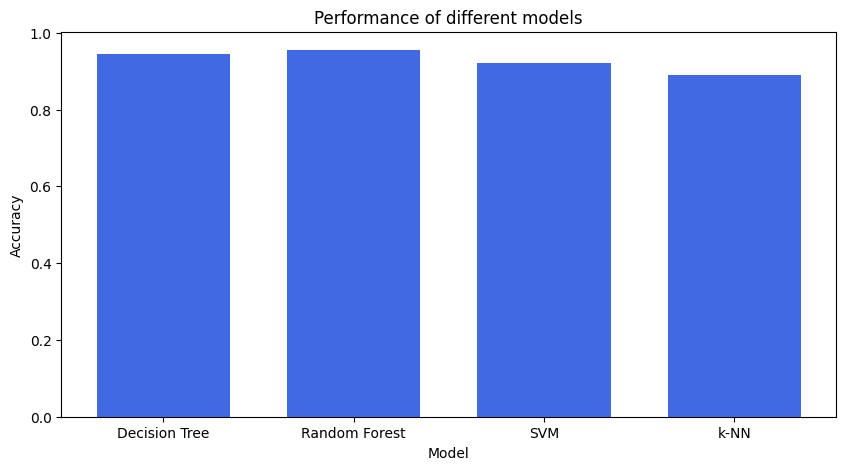

In [43]:
# Plot model performance
model_names = list(results.keys())
model_scores = list(results.values())
fig = plt.figure(figsize=(10, 5))
plt.bar(model_names, model_scores, color='royalblue', width=0.7)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Performance of different models')
plt.show()

In [44]:
# Predict with the best model (choose the one with the highest score)
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
X_test = df_enc_test
predictions = best_model.predict(X_test)

In [45]:
# Merge the test data ID with the prediction result.
data_test = pd.read_csv('/content/drive/My Drive/data/test.csv')
submission = pd.DataFrame({
        "id": data_test["id"],
        "churn": predictions
    })
submission.head()

,id,churn
0,1,no
1,2,no
2,3,yes
3,4,no
4,5,no


In [46]:
# Save the final result of the test data prediction in CSV format.
submission.to_csv('/content/drive/My Drive/data/Prediction_result2.csv')